In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# Cross - correlation

# step = 1
def corr2d(X, K):
    h, w = K.shape
    y = torch.zeros(X.shape[0] - h + 1, X.shape[1] - w + 1)
    for i in range(y.shape[0]):
        for j in range(y.shape[1]):
            y[i, j] = (X[i:i+h, j:j+w] * K).sum()
    return y

In [12]:
a = torch.arange(0, 9, 1).view(3, 3)
k = torch.arange(0, 4, 1).view(2, 2)
c = corr2d(a, k)
c

tensor([[19., 25.],
        [37., 43.]])

Text(0.5, 1.0, 'edge')

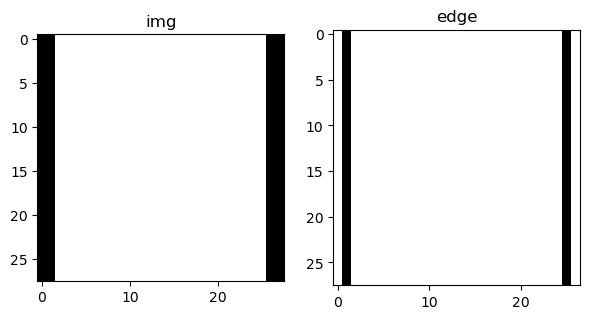

In [46]:
# Edge detection
img = torch.ones((28, 28))
img[:, 2:26] = 0
plt.subplots(1, 2, figsize=(7, 7))
plt.subplot(1, 2, 1); plt.imshow(img, cmap='gray_r'); plt.title("img")

img2 = corr2d(img, torch.tensor([-1, 1]).view(1, -1))
plt.subplot(1, 2, 2); plt.imshow(torch.abs(img2), cmap='gray_r') ; plt.title("edge")

In [58]:
# Train 
torch.manual_seed(42)

Kernal = torch.randn((1, 2), dtype=torch.float, requires_grad=True)
Bias = torch.zeros((1, 1), dtype=torch.float, requires_grad=True)
parameters = [Kernal, Bias]
lr = 0.1

for i in range(1000):
    # forward pass
    img_hat = corr2d(img, Kernal) + Bias
    l = ((img_hat - img2)**2).mean()
    
    # backward pass
    for p in parameters:
        p.grad = None
    l.backward()
    for p in parameters:
        p.data += -lr * p.grad
    
    if i % 200 == 0:
        print(f'epoch {i:5d} loss: {l.item():10f}')
print(f'epoch {i+1:5d} loss: {l.item():10f}')

epoch     0 loss:   0.110337
epoch   200 loss:   0.004613
epoch   400 loss:   0.000236
epoch   600 loss:   0.000012
epoch   800 loss:   0.000001
epoch  1000 loss:   0.000000


In [59]:
print(Kernal)
print(Bias)

tensor([[-0.9993,  0.9993]], requires_grad=True)
tensor([[-1.9565e-14]], requires_grad=True)


In [76]:
# Multi-channel convolution
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                  [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

def corr2d_multi_in(x, k):
    c, h, w = k.shape
    
    # step = 1
    out = torch.zeros(x.shape[1] - h + 1, x.shape[2] - w + 1)
    for i in range(c):
        out += corr2d(x[i], k[i])
    return out  

print(corr2d_multi_in(X, K))

tensor([[ 56.,  72.],
        [104., 120.]])


In [95]:
X = torch.tensor([[[0, 1, 2], [3, 4, 5], [6, 7, 8]],
                  [[1, 2, 3], [4, 5, 6], [7, 8, 9]]])
K = torch.tensor([[[0, 1], [2, 3]], [[1, 2], [3, 4]]])

def corr2d_multi_in_out(x, K):
    c_o, c_i, h, w = K.shape
    out = []
    for k in K:
        out.append(corr2d_multi_in(x, k))
    
    y = torch.stack(out)
    return y

K = torch.stack([K, K+1, K+2])
print(K.shape)
print(corr2d_multi_in_out(X, K))

torch.Size([3, 2, 2, 2])
tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])


In [7]:
a = nn.Conv2d(3, 5, 2)
for p in a.parameters():
    print(p.shape)

torch.Size([5, 3, 2, 2])
torch.Size([5])


# Build Lenet

1.0
torch.Size([60000, 28, 28]) torch.Size([60000])


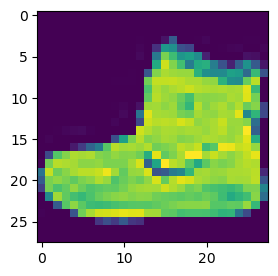

In [2]:
import torchvision
from torchvision import transforms
import torch.utils.data as Data

# Get Fashion-MNIST
root = 'Datasets/FashionMNIST'
train_data = torchvision.datasets.FashionMNIST(root, download=False, train=True, transform=transforms.ToTensor())   # ()
test_data = torchvision.datasets.FashionMNIST(root, download=False, train=False, transform=transforms.ToTensor())
batch_size = 256

train_X, train_y = train_data.data.float().div(255), train_data.targets
test_X, test_y = test_data.data.float().div(255), test_data.targets
print(train_X.max().item())

print(train_X.shape, train_y.shape)
plt.figure(figsize=(3, 3)); plt.imshow(train_X[0].squeeze())

In [109]:
train_iter = Data.DataLoader(train_data, batch_size=128, shuffle=True)
for mx, my in train_iter:
    print(mx.shape)
    print(my.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [3]:
# Build Lenet
class Lenet(nn.Module):
    def __init__(self, img_size, img_class): # consider h = w , c = 1
        super().__init__()
        self.size = img_size
        self.classes = img_class
        self.c1 = nn.Conv2d(1, 6, 5)    # (in_channel, out_channel, kernal_size, ...) more details in pytorch documentation
        self.s2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(6, 6, 1)
        )
        self.c3 = nn.Conv2d(6, 16, 5)
        self.s4 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(16, 16, 1)
        )
        self.c5 = nn.Conv2d(16, 120, int(img_size/4 - 3))
        self.f6 = nn.Linear(120, 84)
        self.f7 = nn.Linear(84, img_class)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, img):
        x = self.c1(img)   # 256, 6, 24, 24
        x = self.s2(x)   # 256, 6, 12, 12
        x = self.sigmoid(x) # 256, 6, 12, 12
        x = self.c3(x)  # 256, 16, 8, 8
        x = self.s4(x)  # 256, 16, 4, 4
        x = self.sigmoid(x) # 256, 16, 4, 4
        x = self.c5(x)  # 256, 120, 1, 1
        x = self.sigmoid(x).view(x.shape[0], -1) # 256, 120
        x = self.f6(x)  # 256, 84
        x = self.sigmoid(x)
        x = self.f7(x) # 256, 10(classes)
        return x

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
test_X = test_X.unsqueeze(1).to(device)
test_y = test_y.to(device)
train_X = train_X.unsqueeze(1).to(device)
train_y = train_y.to(device)


In [112]:
print(train_X.shape, train_X.device)

torch.Size([60000, 1, 28, 28]) cuda:0


In [5]:
# Train 
torch.manual_seed(42)

net = nn.Sequential(
    Lenet(28, 10)
)
loss = nn.CrossEntropyLoss()
loss_train = []
loss_test = []
num_epoch = 10000
batch_size = 256
lr = 0.01
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

net.to(device)
loss.to(device)


for i in range(num_epoch):
    
    # batch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    X, y = train_X[ix], train_y[ix]
    
    # forward pass
    out = net(X)
    l = loss(out, y)
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    # track stats
    if i % 1000 == 0:
        train_loss = loss(net(train_X), train_y).item()
        test_loss = loss(net(test_X), test_y).item()
        
        loss_train.append(train_loss)
        loss_test.append(test_loss)
        print(f'epoch {i :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

train_loss = l.item()
test_loss = loss(net(test_X), test_y).item()

loss_train.append(train_loss)
loss_test.append(test_loss)
print(f'epoch {i+1 :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

epoch     0 /  10000 train_loss 2.380706, test_loss 2.380698
epoch  1000 /  10000 train_loss 0.535223, test_loss 0.569149
epoch  2000 /  10000 train_loss 0.382097, test_loss 0.430154
epoch  3000 /  10000 train_loss 0.352719, test_loss 0.406449
epoch  4000 /  10000 train_loss 0.346201, test_loss 0.407121
epoch  5000 /  10000 train_loss 0.304148, test_loss 0.376542
epoch  6000 /  10000 train_loss 0.303145, test_loss 0.389733
epoch  7000 /  10000 train_loss 0.281296, test_loss 0.364729
epoch  8000 /  10000 train_loss 0.268418, test_loss 0.371466
epoch  9000 /  10000 train_loss 0.259642, test_loss 0.361134
epoch  9999 /  10000 train_loss 0.223086, test_loss 0.350868


In [114]:
print(train_X.shape)

torch.Size([60000, 1, 28, 28])


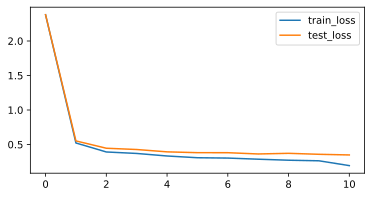

In [115]:
plt.figure(figsize=(6, 3))
plt.plot(loss_train, label='train_loss') ; plt.plot(loss_test, label='test_loss')
plt.legend()

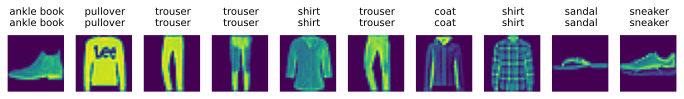

In [116]:
from d2lzh_pytorch import  get_fashion_mnist_labels, show_fashion_mnist
# Predict by trained weights
net.to("cpu")
X = test_X[:10].to("cpu"); y = test_y[:10].to("cpu")
names = get_fashion_mnist_labels(y)

y_hat = torch.softmax(net(X), dim=1)
y_hat = y_hat.argmax(dim=1)
name_hat = get_fashion_mnist_labels(y_hat)

titles = []
for n1, n2 in zip(names, name_hat):
    title = n1 + '\n' + n2
    titles.append(title)
    
show_fashion_mnist(X.squeeze(), titles)


In [76]:
print(test_X.unsqueeze(1).shape)
print(test_y.shape)

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


# Add BN to Lenet

In [6]:
class BatchNormalization2d(nn.Module):
    def __init__(self, num_channel, momentum):
        super().__init__()
        self.channels = num_channel
        self.moving_mean = torch.zeros(1, num_channel, 1, 1)
        self.moving_std = torch.zeros(1, num_channel, 1, 1)
        self.gamma = nn.Parameter(torch.ones(1, num_channel, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, num_channel, 1, 1))
        self.momentum = momentum
    
    def forward(self, x):   # x:(batch_size, channels, height, width)
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_std = self.moving_std.to(x.device)

        if self.training:
            mean = x.mean(dim=[0, 2, 3], keepdim=True)
            std = x.std(dim=[0, 2, 3], keepdim=True)
            self.moving_mean = (1 - self.momentum) * self.moving_mean + self.momentum * mean
            self.moving_std = (1 - self.momentum) * self.moving_std + self.momentum * std
        else:
            mean = self.moving_mean
            std = self.moving_std
        x_nor = (x - mean) / torch.sqrt_(std**2 + 1e-11)
        
        return x_nor * self.gamma + self.beta

class BatchNormalization1d(nn.Module):
    def __init__(self, num_channel, momentum):
        super().__init__()
        self.channels = num_channel
        self.moving_mean = torch.zeros(1, num_channel)
        self.moving_std = torch.zeros(1, num_channel)
        self.gamma = nn.Parameter(torch.ones(1, num_channel))
        self.beta = nn.Parameter(torch.zeros(1, num_channel))
        self.momentum = momentum
    
    def forward(self, x):   # x:(batch_size, features)
        if self.moving_mean.device != x.device:
            self.moving_mean = self.moving_mean.to(x.device)
            self.moving_std = self.moving_std.to(x.device)
            
        if self.training:
            mean = x.mean(dim=0, keepdim=True)
            std = x.std(dim=0, keepdim=True)
            self.moving_mean = (1 - self.momentum) * self.moving_mean + self.momentum * mean
            self.moving_std = (1 - self.momentum) * self.moving_std + self.momentum * std
        else:
            mean = self.moving_mean
            std = self.moving_std
        x_nor = (x - mean) / torch.sqrt_(std**2 + 1e-11)
        
        return x_nor * self.gamma + self.beta

In [7]:
# Build Lenet
class LenetBN(nn.Module):
    def __init__(self, img_size, img_class): # consider h = w , c = 1
        super().__init__()
        self.size = img_size
        self.classes = img_class
        self.c1 = nn.Conv2d(1, 6, 5)    # (in_channel, out_channel, kernal_size, ...) more details in pytorch documentation
        self.s2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(6, 6, 1)
        )
        self.bn2 = BatchNormalization2d(6, 0.1)
        self.c3 = nn.Conv2d(6, 16, 5)
        self.s4 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(16, 16, 1)
        )
        self.bn4 = BatchNormalization2d(16, 0.1)
        self.c5 = nn.Conv2d(16, 120, int(img_size/4 - 3))
        self.bn5 = BatchNormalization2d(120, 0.1)
        self.f6 = nn.Linear(120, 84)
        self.bn6 = BatchNormalization1d(84, 0.1)
        self.f7 = nn.Linear(84, img_class)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, img):
        x = self.c1(img)   # 256, 6, 24, 24
        x = self.s2(x)   # 256, 6, 12, 12
        x = self.bn2(x)
        x = self.sigmoid(x) # 256, 6, 12, 12
        x = self.c3(x)  # 256, 16, 8, 8
        x = self.s4(x)  # 256, 16, 4, 4
        x = self.bn4(x)
        x = self.sigmoid(x) # 256, 16, 4, 4
        x = self.c5(x)  # 256, 120, 1, 1
        x = self.bn5(x)
        x = self.sigmoid(x).view(x.shape[0], -1) # 256, 120
        x = self.f6(x)  # 256, 84
        x = self.bn6(x)
        x = self.sigmoid(x)
        x = self.f7(x) # 256, 10(classes)
        return x

In [8]:
train_X.device, train_y.device, test_X.device, test_y.device

(device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0),
 device(type='cuda', index=0))

In [17]:
torch.cuda.empty_cache()

In [18]:
# Train 
torch.manual_seed(42)

net = nn.Sequential(
    LenetBN(28, 10)
)
loss = nn.CrossEntropyLoss()
loss_train = []
loss_test = []
num_epoch = 4000
batch_size = 256
lr = 0.01
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

net.to(device)
loss.to(device)


for i in range(num_epoch):
    
    # batch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    X, y = train_X[ix], train_y[ix]
    
    # forward pass
    out = net(X)
    l = loss(out, y)
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    # track stats
    if i % 1000 == 0:
        train_loss = loss(net(train_X), train_y).item()
        test_loss = loss(net(test_X), test_y).item()
        
        loss_train.append(train_loss)
        loss_test.append(test_loss)
        print(f'epoch {i :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

train_loss = l.item()
test_loss = loss(net(test_X), test_y).item()

loss_train.append(train_loss)
loss_test.append(test_loss)
print(f'epoch {i :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

epoch     0 /  4000 train_loss 2.015337, test_loss 2.017823
epoch  1000 /  4000 train_loss 0.300137, test_loss 0.344679
epoch  2000 /  4000 train_loss 0.245451, test_loss 0.308559
epoch  3000 /  4000 train_loss 0.229192, test_loss 0.317251
epoch  3999 /  4000 train_loss 0.153401, test_loss 0.308056


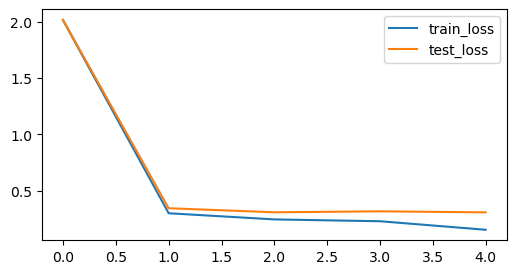

In [19]:
plt.figure(figsize=(6, 3))
plt.plot(loss_train, label='train_loss') ; plt.plot(loss_test, label='test_loss')
plt.legend()

In [11]:
# Build Lenet
class LenetNN(nn.Module):
    def __init__(self, img_size, img_class): # consider h = w , c = 1
        super().__init__()
        self.size = img_size
        self.classes = img_class
        self.c1 = nn.Conv2d(1, 6, 5)    # (in_channel, out_channel, kernal_size, ...) more details in pytorch documentation
        self.s2 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(6, 6, 1)
        )
        self.bn2 = nn.BatchNorm2d(6, 0.1)
        self.c3 = nn.Conv2d(6, 16, 5)
        self.s4 = nn.Sequential(
            nn.AvgPool2d(2),
            nn.Conv2d(16, 16, 1)
        )
        self.bn4 = nn.BatchNorm2d(16, 0.1)
        self.c5 = nn.Conv2d(16, 120, int(img_size/4 - 3))
        self.bn5 = nn.BatchNorm2d(120, 0.1)
        self.f6 = nn.Linear(120, 84)
        self.bn6 = nn.BatchNorm1d(84, 0.1)
        self.f7 = nn.Linear(84, img_class)
        
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, img):
        x = self.c1(img)   # 256, 6, 24, 24
        x = self.s2(x)   # 256, 6, 12, 12
        x = self.bn2(x)
        x = self.sigmoid(x) # 256, 6, 12, 12
        x = self.c3(x)  # 256, 16, 8, 8
        x = self.s4(x)  # 256, 16, 4, 4
        x = self.bn4(x)
        x = self.sigmoid(x) # 256, 16, 4, 4
        x = self.c5(x)  # 256, 120, 1, 1
        x = self.bn5(x)
        x = self.sigmoid(x).view(x.shape[0], -1) # 256, 120
        x = self.f6(x)  # 256, 84
        x = self.bn6(x)
        x = self.sigmoid(x)
        x = self.f7(x) # 256, 10(classes)
        return x

In [14]:
torch.cuda.empty_cache()

In [15]:
# Train 
torch.manual_seed(42)

net = nn.Sequential(
    LenetNN(28, 10)
)
loss = nn.CrossEntropyLoss()
loss_train = []
loss_test = []
num_epoch = 10000
batch_size = 256
lr = 0.01
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

net.to(device)
loss.to(device)


for i in range(num_epoch):
    
    # batch
    ix = torch.randint(0, train_X.shape[0], (batch_size,))
    X, y = train_X[ix], train_y[ix]
    
    # forward pass
    out = net(X)
    l = loss(out, y)
    
    # backward pass
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    
    # track stats
    if i % 1000 == 0:
        train_loss = loss(net(train_X), train_y).item()
        test_loss = loss(net(test_X), test_y).item()
        
        loss_train.append(train_loss)
        loss_test.append(test_loss)
        print(f'epoch {i :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

train_loss = l.item()
test_loss = loss(net(test_X), test_y).item()

loss_train.append(train_loss)
loss_test.append(test_loss)
print(f'epoch {i+1 :5d} / {num_epoch : 5d} train_loss {train_loss:7f}, test_loss {test_loss:7f}')

epoch     0 /  10000 train_loss 2.327312, test_loss 2.327315
epoch  1000 /  10000 train_loss 0.330723, test_loss 0.372085
epoch  2000 /  10000 train_loss 0.259322, test_loss 0.321974
epoch  3000 /  10000 train_loss 0.226601, test_loss 0.312996
epoch  4000 /  10000 train_loss 0.197473, test_loss 0.299187
epoch  5000 /  10000 train_loss 0.178647, test_loss 0.306745
epoch  6000 /  10000 train_loss 0.161495, test_loss 0.317413
epoch  7000 /  10000 train_loss 0.159031, test_loss 0.347953
epoch  8000 /  10000 train_loss 0.136928, test_loss 0.347648
epoch  9000 /  10000 train_loss 0.119152, test_loss 0.344126
epoch  9999 /  10000 train_loss 0.134045, test_loss 0.356125


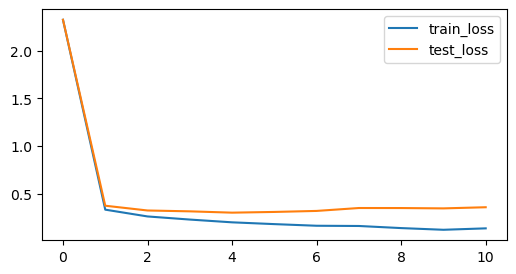

In [16]:
plt.figure(figsize=(6, 3))
plt.plot(loss_train, label='train_loss') ; plt.plot(loss_test, label='test_loss')
plt.legend()